# 오늘 밤 유럽 축구, 어디가 이길까_ 데이터로 분석해보기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

In [3]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'gustn6839'
os.environ['KAGGLE_KEY'] = '095a3df6ddaa7cf2884cd7c4cb2216d9'

In [4]:
!kaggle datasets download -d hugomathien/soccer
!unzip *zip

 52% 17.0M/32.7M [00:00<00:00, 71.6MB/s]
100% 32.7M/32.7M [00:00<00:00, 109MB/s] 
Archive:  soccer.zip
  inflating: database.sqlite         


### sqlite3와 Pandas로 sqlite 데이터베이스 읽어들이기

In [5]:
import sqlite3

In [6]:
# sqlite3.connect()와 pd.read_sql_query()로 csv파일 읽어들이기
conn = sqlite3.connect('database.sqlite')
df_country = pd.read_sql_query('SELECT * from Country', conn)
df_league = pd.read_sql_query('SELECT * from League', conn)
df_match = pd.read_sql_query('SELECT * from Match', conn)
df_player = pd.read_sql_query('SELECT * from Player', conn)
df_player_att = pd.read_sql_query('SELECT * from Player_Attributes', conn)
df_team = pd.read_sql_query('SELECT * from Team', conn)
df_team_att = pd.read_sql_query('SELECT * from Team_Attributes', conn)

In [8]:
df_team_att.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [16]:
for c, num in zip(df_match.columns, df_match.isna().sum()):
  print(c, num)

id 0
country_id 0
league_id 0
season 0
stage 0
date 0
match_api_id 0
home_team_api_id 0
away_team_api_id 0
home_team_goal 0
away_team_goal 0
home_player_X1 1821
home_player_X2 1821
home_player_X3 1832
home_player_X4 1832
home_player_X5 1832
home_player_X6 1832
home_player_X7 1832
home_player_X8 1832
home_player_X9 1832
home_player_X10 1832
home_player_X11 1832
away_player_X1 1832
away_player_X2 1832
away_player_X3 1832
away_player_X4 1832
away_player_X5 1832
away_player_X6 1832
away_player_X7 1832
away_player_X8 1832
away_player_X9 1833
away_player_X10 1833
away_player_X11 1839
home_player_Y1 1821
home_player_Y2 1821
home_player_Y3 1832
home_player_Y4 1832
home_player_Y5 1832
home_player_Y6 1832
home_player_Y7 1832
home_player_Y8 1832
home_player_Y9 1832
home_player_Y10 1832
home_player_Y11 1832
away_player_Y1 1832
away_player_Y2 1832
away_player_Y3 1832
away_player_Y4 1832
away_player_Y5 1832
away_player_Y6 1832
away_player_Y7 1832
away_player_Y8 1832
away_player_Y9 1833
away_player_Y

In [18]:
# goal부터 drop 시키기
df_match.drop(df_match.columns[-38:], axis=1, inplace=True)

In [19]:
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 데이터프레임간의 관계 파악

In [21]:
# 데이터프레임 간 중복되는 Column 확인 및 유용한 Column 식별
# unique() 또는 map()을 활용하여 Column 관계 확인

df_player_att['player_api_id'].value_counts().mean()

16.634538878842676

In [30]:
# float 형태를 int로 바꾸고 id 값을 player_api_id 대체한 후 그룹핑하여 overall rating 파악. 최종적으로 isna 됐는지 확인.
df_match['home_player_1'].dropna().apply(int).map(df_player_att.groupby('player_api_id').mean()['overall_rating']).isna().sum()

0

In [32]:
# 25000개 중 178개가 NaN 값이며, 이 정도는 drop하는 것으로 결정.
df_match['away_team_api_id'].map(df_team_att.groupby('team_api_id').mean()['buildUpPlaySpeed']).isna().sum()

178

### 선수 특성 사이의 상관성 파악하기

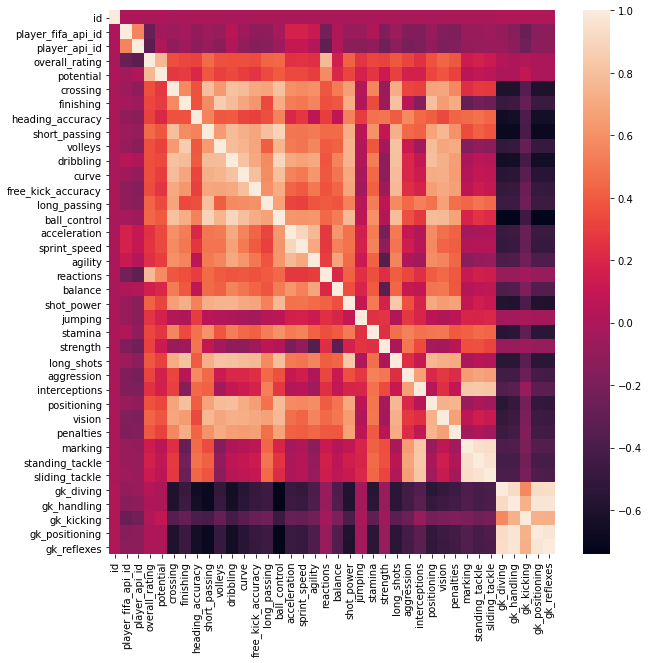

In [35]:
# DF의 corr() 메소드와 Seaborn의 heatmap() 메소드 이용하여 Person's correlation Visualization
fig = plt.figure(figsize=(10,10))
sns.heatmap(df_player_att.corr())

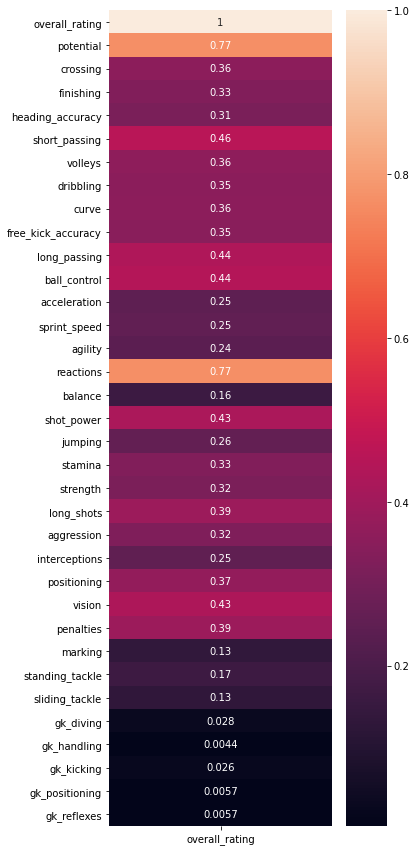

In [36]:
# Overall_rating 관련하여 확인
fig = plt.figure(figsize=(5,15))
sns.heatmap(df_player_att.drop(['id', 'player_fifa_api_id', 'player_api_id'], axis=1).corr()[['overall_rating']], annot=True)

- 선수들의 어떤 능력이 좋아야 좋은 평가를 받는가?
  > potential, reaction, passing, ball_control 등 다양한 요소가 있다.

### 매치 데이터프레임에 팀별 특성 데이터프레임 통합하기

In [37]:
# map() 메소드 활용
df_team_att.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [38]:
df_team_att.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

- 많이 비어있는 항목인 buildUpPlayDribbling은 drop.

In [39]:
df_team_att.drop('buildUpPlayDribbling', axis=1, inplace=True)

In [40]:
df_team_att.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
       'buildUpPlayPassing', 'buildUpPlayPassingClass',
       'buildUpPlayPositioningClass', 'chanceCreationPassing',
       'chanceCreationPassingClass', 'chanceCreationCrossing',
       'chanceCreationCrossingClass', 'chanceCreationShooting',
       'chanceCreationShootingClass', 'chanceCreationPositioningClass',
       'defencePressure', 'defencePressureClass', 'defenceAggression',
       'defenceAggressionClass', 'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [41]:
# aggregation 위한 Function 설정. Numerical Data는 mean을 사용하고, Categorical Data는 most 값 사용.
def most(x):
  return x.value_counts().index[0]

In [42]:
# categorical data는 뒤에 Class라고 붙어있음.
team_map = df_team_att.groupby('team_api_id').aggregate(
    {
        'buildUpPlaySpeed': 'mean',
       'buildUpPlaySpeedClass':most, 'buildUpPlayDribblingClass':most,
       'buildUpPlayPassing':'mean', 'buildUpPlayPassingClass':most,
       'buildUpPlayPositioningClass':most, 'chanceCreationPassing':'mean',
       'chanceCreationPassingClass':most, 'chanceCreationCrossing':'mean',
       'chanceCreationCrossingClass':most, 'chanceCreationShooting':'mean',
       'chanceCreationShootingClass':most, 'chanceCreationPositioningClass':most,
       'defencePressure':'mean', 'defencePressureClass':most, 'defenceAggression':'mean',
       'defenceAggressionClass':most, 'defenceTeamWidth':'mean', 'defenceTeamWidthClass':most,
       'defenceDefenderLineClass':most
    }
)

In [62]:
team_map.head()

,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
away_team_api_id,,,,,,,,,,,,,,,,,,,,
1601,47.333333,Balanced,Little,46.166667,Mixed,Organised,55.500000,Normal,60.333333,Normal,53.5,Normal,Organised,47.166667,Medium,47.333333,Press,49.333333,Normal,Cover
1773,52.000000,Balanced,Little,50.000000,Mixed,Organised,50.000000,Normal,53.000000,Normal,54.0,Normal,Organised,43.000000,Medium,44.000000,Press,50.000000,Normal,Cover
1957,47.166667,Balanced,Little,52.666667,Mixed,Organised,50.833333,Normal,36.333333,Normal,67.0,Normal,Organised,49.333333,Medium,56.333333,Press,53.666667,Normal,Cover
2033,49.000000,Balanced,Little,48.400000,Mixed,Organised,51.800000,Normal,44.200000,Normal,48.2,Normal,Free Form,42.200000,Medium,33.800000,Contain,45.400000,Normal,Cover
2182,60.333333,Fast,Little,49.000000,Mixed,Organised,56.666667,Normal,57.333333,Normal,68.0,Lots,Organised,51.666667,Medium,48.500000,Press,54.500000,Normal,Cover


In [46]:
# 팀 정보를 매치 데이터프레임에 통합하기
df = df_match[['home_team_goal', 'away_team_goal']].copy()

In [48]:
for team in ['home_', 'away_']:
  team_map.index.name = team + 'team_api_id'
  for col in team_map.columns:
    df[team + col] = df_match[team_map.index.name].map(team_map[col])

In [49]:
df.head()

,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlaySpeedClass,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,away_buildUpPlaySpeed,away_buildUpPlaySpeedClass,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,1,1,56.333333,Balanced,Little,44.333333,Mixed,Organised,55.666667,Normal,52.333333,Normal,55.833333,Normal,Organised,49.166667,Medium,50.666667,Press,59.833333,Normal,Cover,46.000000,Balanced,Little,41.500000,Mixed,Organised,46.000000,Normal,53.500000,Normal,53.750000,Normal,Organised,48.250000,Medium,49.000000,Press,58.750000,Normal,Cover
1,0,0,55.500000,Balanced,Little,52.666667,Mixed,Organised,50.000000,Normal,49.333333,Normal,41.500000,Little,Organised,48.666667,Medium,56.166667,Press,47.833333,Normal,Cover,64.000000,Balanced,Little,53.500000,Mixed,Organised,44.000000,Normal,47.666667,Normal,54.333333,Normal,Organised,48.833333,Medium,55.166667,Press,55.500000,Normal,Cover
2,0,3,53.666667,Balanced,Little,44.166667,Mixed,Organised,59.000000,Normal,60.333333,Normal,48.000000,Normal,Organised,60.166667,Medium,49.666667,Press,64.666667,Normal,Cover,51.333333,Balanced,Little,45.166667,Mixed,Organised,63.500000,Normal,55.000000,Normal,51.333333,Normal,Organised,59.666667,Medium,47.666667,Press,63.833333,Normal,Cover
3,5,0,54.166667,Balanced,Little,46.333333,Mixed,Organised,44.500000,Normal,64.666667,Normal,44.166667,Normal,Organised,51.333333,Medium,50.000000,Press,45.666667,Normal,Cover,51.666667,Balanced,Little,51.666667,Mixed,Organised,55.000000,Normal,60.666667,Lots,46.000000,Normal,Organised,46.000000,Medium,45.000000,Press,47.000000,Normal,Cover
4,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.666667,Balanced,Little,60.333333,Mixed,Organised,54.666667,Normal,58.833333,Normal,61.333333,Normal,Organised,51.500000,Medium,57.500000,Press,56.500000,Normal,Cover


### 홈과 어웨이의 골 수를 승-무-패 범주로 변환하기

In [52]:
# 홈과 어웨이의 골 수를 범주형 데이터로 변환 (0 : 홈팀 승, 1 : 무승부, 2: 어웨이팀 승)


df['matchResult'] = df[['home_team_goal', 'away_team_goal']].aggregate(lambda x: 0 if x[0] > x[1] else 1 if x[0] == x[1] else 2, axis=1)

In [63]:
df.dropna(inplace=True)

In [54]:
df.drop(['home_team_goal', 'away_team_goal'], axis=1, inplace=True)

### get_dummies 이용하여 범주형 데이터 전처리하기

In [55]:
df.columns

Index(['home_buildUpPlaySpeed', 'home_buildUpPlaySpeedClass',
       'home_buildUpPlayDribblingClass', 'home_buildUpPlayPassing',
       'home_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass',
       'home_chanceCreationPassing', 'home_chanceCreationPassingClass',
       'home_chanceCreationCrossing', 'home_chanceCreationCrossingClass',
       'home_chanceCreationShooting', 'home_chanceCreationShootingClass',
       'home_chanceCreationPositioningClass', 'home_defencePressure',
       'home_defencePressureClass', 'home_defenceAggression',
       'home_defenceAggressionClass', 'home_defenceTeamWidth',
       'home_defenceTeamWidthClass', 'home_defenceDefenderLineClass',
       'away_buildUpPlaySpeed', 'away_buildUpPlaySpeedClass',
       'away_buildUpPlayDribblingClass', 'away_buildUpPlayPassing',
       'away_buildUpPlayPassingClass', 'away_buildUpPlayPositioningClass',
       'away_chanceCreationPassing', 'away_chanceCreationPassingClass',
       'away_chanceCreationCrossi

In [64]:
col_cats = list(filter(lambda s: s.find('Class') >= 0, df.columns))
df_cats = pd.get_dummies(df[col_cats], drop_first=True)
df_cats.head()

,home_buildUpPlaySpeedClass_Fast,home_buildUpPlaySpeedClass_Slow,home_buildUpPlayDribblingClass_Normal,home_buildUpPlayPassingClass_Mixed,home_buildUpPlayPassingClass_Short,home_buildUpPlayPositioningClass_Organised,home_chanceCreationPassingClass_Risky,home_chanceCreationPassingClass_Safe,home_chanceCreationCrossingClass_Lots,home_chanceCreationCrossingClass_Normal,home_chanceCreationShootingClass_Lots,home_chanceCreationShootingClass_Normal,home_chanceCreationPositioningClass_Organised,home_defencePressureClass_High,home_defencePressureClass_Medium,home_defenceAggressionClass_Double,home_defenceAggressionClass_Press,home_defenceTeamWidthClass_Normal,home_defenceTeamWidthClass_Wide,home_defenceDefenderLineClass_Offside Trap,away_buildUpPlaySpeedClass_Fast,away_buildUpPlaySpeedClass_Slow,away_buildUpPlayDribblingClass_Normal,away_buildUpPlayPassingClass_Mixed,away_buildUpPlayPassingClass_Short,away_buildUpPlayPositioningClass_Organised,away_chanceCreationPassingClass_Risky,away_chanceCreationPassingClass_Safe,away_chanceCreationCrossingClass_Lots,away_chanceCreationCrossingClass_Normal,away_chanceCreationShootingClass_Lots,away_chanceCreationShootingClass_Normal,away_chanceCreationPositioningClass_Organised,away_defencePressureClass_High,away_defencePressureClass_Medium,away_defenceAggressionClass_Double,away_defenceAggressionClass_Press,away_defenceTeamWidthClass_Normal,away_defenceTeamWidthClass_Wide,away_defenceDefenderLineClass_Offside Trap
0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
2,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
3,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,0
5,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0


- 클래스가 붙은 것은 1로 변환하여 One-Hot Encoding 완료.

### Standard Scaler 이용해 수치형 데이터 표준화

In [57]:
from sklearn.preprocessing import StandardScaler

In [65]:
X_num = df.drop(['matchResult'] + col_cats, axis=1)
scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(data=X_scaled, index=X_num.index, columns=X_num.columns)

X_cat = df_cats
X = pd.concat([X_scaled, X_cat], axis=1)
y = df['matchResult']

In [66]:
X

,home_buildUpPlaySpeed,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,home_buildUpPlaySpeedClass_Fast,home_buildUpPlaySpeedClass_Slow,home_buildUpPlayDribblingClass_Normal,home_buildUpPlayPassingClass_Mixed,home_buildUpPlayPassingClass_Short,home_buildUpPlayPositioningClass_Organised,home_chanceCreationPassingClass_Risky,home_chanceCreationPassingClass_Safe,home_chanceCreationCrossingClass_Lots,home_chanceCreationCrossingClass_Normal,home_chanceCreationShootingClass_Lots,home_chanceCreationShootingClass_Normal,home_chanceCreationPositioningClass_Organised,home_defencePressureClass_High,home_defencePressureClass_Medium,home_defenceAggressionClass_Double,home_defenceAggressionClass_Press,home_defenceTeamWidthClass_Normal,home_defenceTeamWidthClass_Wide,home_defenceDefenderLineClass_Offside Trap,away_buildUpPlaySpeedClass_Fast,away_buildUpPlaySpeedClass_Slow,away_buildUpPlayDribblingClass_Normal,away_buildUpPlayPassingClass_Mixed,away_buildUpPlayPassingClass_Short,away_buildUpPlayPositioningClass_Organised,away_chanceCreationPassingClass_Risky,away_chanceCreationPassingClass_Safe,away_chanceCreationCrossingClass_Lots,away_chanceCreationCrossingClass_Normal,away_chanceCreationShootingClass_Lots,away_chanceCreationShootingClass_Normal,away_chanceCreationPositioningClass_Organised,away_defencePressureClass_High,away_defencePressureClass_Medium,away_defenceAggressionClass_Double,away_defenceAggressionClass_Press,away_defenceTeamWidthClass_Normal,away_defenceTeamWidthClass_Wide,away_defenceDefenderLineClass_Offside Trap
0,0.524473,-0.491432,0.513747,-0.211037,0.268240,0.405160,0.214042,1.266800,-0.828060,-0.882555,-0.958503,-0.050280,-0.069565,0.269502,-0.072044,1.086301,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
1,0.415403,0.658405,-0.349147,-0.624041,-2.056305,0.331100,1.158473,-0.731538,1.527352,0.773235,-1.263055,-0.853318,0.025030,0.355909,0.986891,0.545116,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
2,0.175451,-0.514429,1.021331,0.890309,-1.002151,2.034483,0.042327,2.071686,-0.130160,-0.376619,1.706325,0.156215,-0.461459,1.960604,-0.301003,1.932770,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
3,0.240893,-0.215471,-1.186661,1.486870,-1.623832,0.726087,0.099566,-1.092349,-0.086541,0.520267,0.411980,0.936309,-1.326330,-0.063780,-0.758921,-0.870290,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,0
5,0.568100,-0.077490,-0.729835,-0.555207,-0.623736,0.182980,1.616379,-0.037670,-0.413682,-0.192642,-0.527055,0.270935,-1.056058,1.071850,0.757932,0.406351,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,0.589914,0.290457,-0.653697,0.179023,-0.110174,0.331100,-0.587293,0.572933,0.559016,-1.669055,1.660643,-2.404328,0.781792,-0.211906,-1.136704,-0.104305,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
25974,-0.618572,0.538822,-1.902355,-1.193069,-1.585990,-0.389752,-0.655979,-0.237504,0.559016,-1.669055,1.660643,-2.404328,0.781792,-0.211906,-1.136704,-0.104305,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
25975,0.088196,1.118340,-2.176450,-0.119258,-1.326506,-0.656369,-2.819584,0.961498,-0.064732,0.635253,0.107428,-0.761542,1.106118,0.232471,-0.186524,-0.315229,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
25976,-0.369895,0.727396,0

### 학습데이터와 테스트데이터 분리

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [68]:
# LR 모델 생성 및 학습
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 학습 결과 평가

In [69]:
from sklearn.metrics import classification_report
pred = model_lr.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.49      0.87      0.63      3484
           1       0.48      0.01      0.01      1972
           2       0.45      0.29      0.36      2233

    accuracy                           0.48      7689
   macro avg       0.47      0.39      0.33      7689
weighted avg       0.48      0.48      0.39      7689



- 48%의 결과를 얻음.
- 어느 정도의 효과인지 알기 위해 baseline을 알아보아야함.

In [70]:
# 승, 패, 무승부 중 가장 많이 일어난 것의 비율 알아보기
print(sum(y_test == 0) / len(y_test))
print(sum(y_test == 1) / len(y_test))
print(sum(y_test == 2) / len(y_test))

0.4531148393809338
0.2564702822213552
0.290414878397711


- 홈팀이 이기는 경우는 45%라는 결과가 나왔고, 학습을 통해 얻은 결과는 3% 향상된 48%임.
- 그렇다면 데이터가 부적절해서 그런 것인지 확인해보아야함.

In [71]:
from xgboost import XGBClassifier

In [72]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [73]:
pred = model_xgb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.51      0.91      0.65      3484
           1       0.34      0.01      0.02      1972
           2       0.52      0.32      0.40      2233

    accuracy                           0.51      7689
   macro avg       0.46      0.41      0.35      7689
weighted avg       0.47      0.51      0.41      7689



- 48%에 비해 51%라는 향상된 결과를 얻음.

### LR 모델 계수로 상관성 파악하기

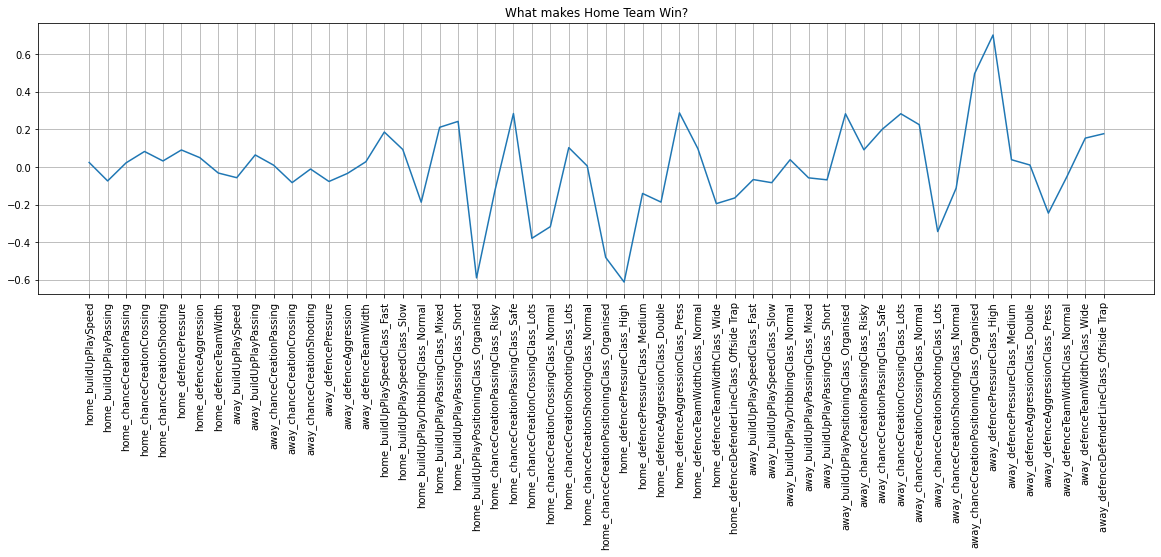

In [78]:
fig = plt.figure(figsize=(20, 5))
plt.plot(X.columns, model_lr.coef_[0])
plt.xticks(rotation=90)
plt.title('What makes Home Team Win?')
plt.grid()
plt.show()

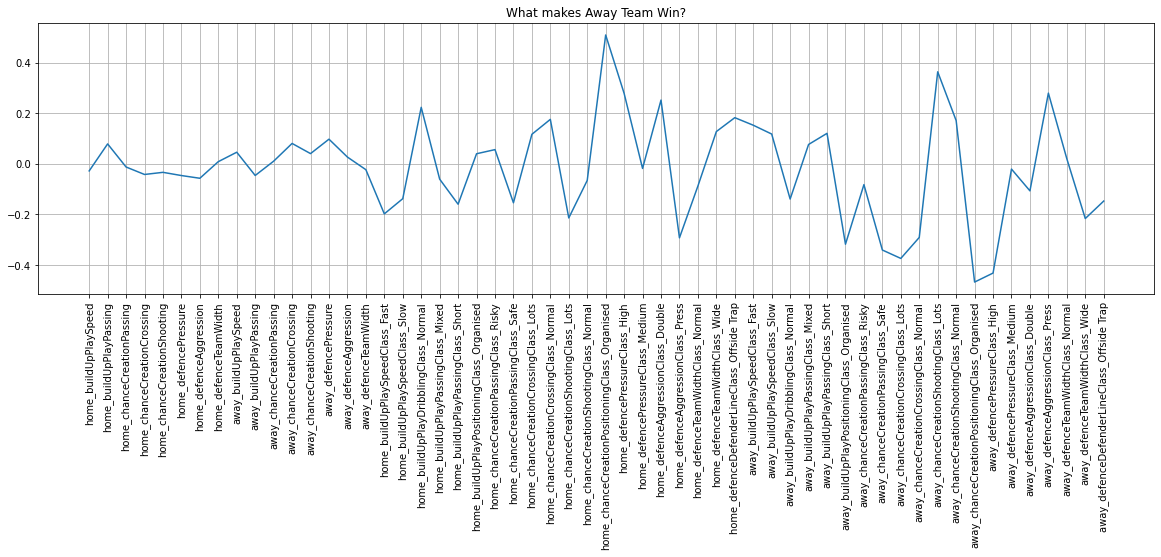

In [80]:
fig = plt.figure(figsize=(20, 5))
plt.plot(X.columns, model_lr.coef_[2])
plt.xticks(rotation=90)
plt.title('What makes Away Team Win?')
plt.grid()
plt.show()

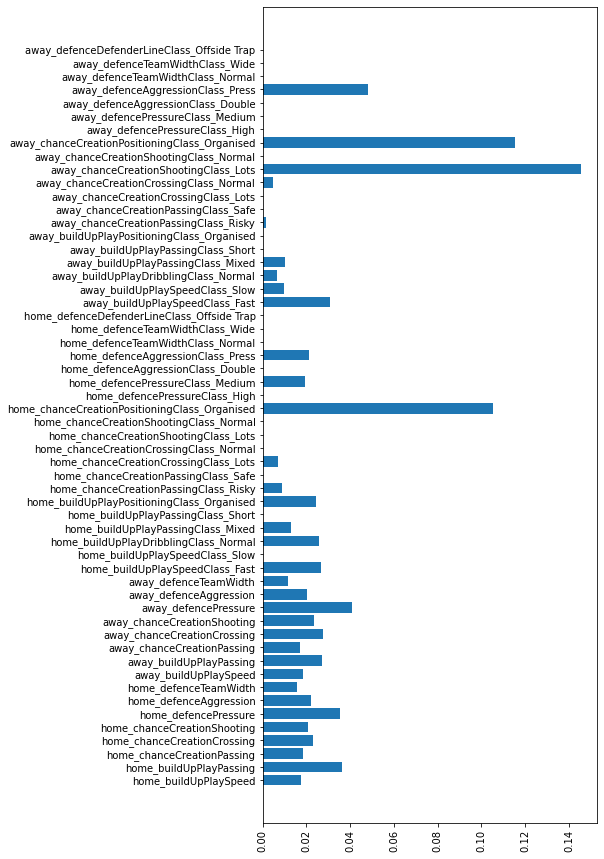

In [85]:
# XGBoost feature_importance_ plot하기
fig = plt.figure(figsize=(6, 15))
plt.barh(X.columns, model_xgb.feature_importances_)
plt.xticks(rotation=90)
plt.show()

# 모델 성능 개선
### 매치 데이터프레임에 선수 특성 데이터프레임 통합

In [86]:
# 유용한 정보만 추출
df_player_att.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [87]:
# 선수 특성 중 유의미한 정보를 매치 데이터프레임에 통합하기
df = df_match[['home_team_goal', 'away_team_goal']].copy()

In [88]:
for team in ['home_', 'away_']:
  team_map.index.name = team + 'team_api_id'
  for col in team_map.columns:
    df[team + col] = df_match[team_map.index.name].map(team_map[col])

In [89]:
df.dropna(inplace=True)

In [90]:
df_player_att.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [92]:
player_map = df_player_att.groupby('player_api_id').mean()['overall_rating']
player_map[:5]

player_api_id
2625    60.142857
2752    69.380952
2768    69.285714
2770    71.133333
2790    70.200000
Name: overall_rating, dtype: float64

In [93]:
# s: home 또는 away player
for col in (s + str(idx) for s in ['home_player_', 'away_player_'] for idx in range(1, 12)):
  df[col + '_rating'] = df_match[col].map(player_map)

In [96]:
df.dropna(inplace=True)

In [97]:
df.head()

,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlaySpeedClass,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,away_buildUpPlaySpeed,away_buildUpPlaySpeedClass,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass,home_player_1_rating,home_player_2_rating,home_player_3_rating,home_player_4_rating,home_player_5_rating,home_player_6_rating,home_player_7_rating,home_player_8_rating,home_player_9_rating,home_player_10_rating,home_player_11_rating,away_player_1_rating,away_player_2_rating,away_player_3_rating,away_player_4_rating,away_player_5_rating,away_player_6_rating,away_player_7_rating,away_player_8_rating,away_player_9_rating,away_player_10_rating,away_player_11_rating
145,2,1,56.666667,Balanced,Little,47.333333,Mixed,Organised,47.5,Normal,49.833333,Normal,50.333333,Normal,Organised,47.666667,Medium,58.833333,Press,52.000000,Normal,Cover,56.333333,Balanced,Little,44.333333,Mixed,Organised,55.666667,Normal,52.333333,Normal,55.833333,Normal,Organised,49.166667,Medium,50.666667,Press,59.833333,Normal,Cover,63.214286,62.733333,70.151515,61.800000,69.192308,61.500000,63.538462,68.040000,54.600000,65.285714,62.666667,64.952381,71.388889,60.750000,66.750000,70.185185,69.333333,68.000000,65.000000,71.666667,64.611111,71.826087
153,1,3,53.666667,Balanced,Little,44.166667,Mixed,Organised,59.0,Normal,60.333333,Normal,48.000000,Normal,Organised,60.166667,Medium,49.666667,Press,64.666667,Normal,Cover,49.166667,Balanced,Little,46.500000,Mixed,Organised,48.833333,Normal,55.833333,Normal,47.666667,Normal,Organised,53.666667,Medium,53.833333,Press,54.666667,Normal,Cover,65.050000,63.142857,62.454545,63.227273,64.625000,71.800000,67.500000,66.000000,69.700000,67.129032,63.500000,71.266667,68.142857,70.375000,69.888889,70.720000,68.444444,68.541667,71.739130,71.190476,69.714286,69.130435
155,2,0,51.333333,Balanced,Little,45.166667,Mixed,Organised,63.5,Normal,55.000000,Normal,51.333333,Normal,Organised,59.666667,Medium,47.666667,Press,63.833333,Normal,Cover,55.500000,Balanced,Little,52.666667,Mixed,Organised,50.000000,Normal,49.333333,Normal,41.500000,Little,Organised,48.666667,Medium,56.166667,Press,47.833333,Normal,Cover,67.888889,71.060606,68.958333,69.823529,72.166667,72.107143,77.972973,71.416667,79.692308,68.086957,70.896552,67.095238,67.625000,61.750000,63.722222,63.411765,64.714286,68.000000,70.521739,67.500000,65.666667,66.083333
162,2,1,56.666667,Balanced,Little,47.333333,Mixed,Organised,47.5,Normal,49.833333,Normal,50.333333,Normal,Organised,47.666667,Medium,58.833333,Press,52.000000,Normal,Cover,51.333333,Balanced,Little,45.166667,Mixed,Organised,63.500000,Normal,55.000000,Normal,51.333333,Normal,Organised,59.666667,Medium,47.666667,Press,63.833333,Normal,Cover,63.214286,62.733333,70.151515,65.285714,68.040000,69.192308,61.800000,63.538462,54.600000,67.846154,62.666667,67.888889,71.060606,72.166667,64.100000,69.407407,72.107143,69.240000,79.692308,77.972973,71.416667,70.896552
168,0,0,55.500000,Balanced,Little,52.666667,Mixed,Organised,50.0,Normal,49.333333,Normal,41.500000,Little,Organised,48.666667,Medium,56.166

In [98]:
# 홈과 어웨이의 골 수를 범주형 데이터로 변환 (0 : 홈팀 승, 1 : 무승부, 2: 어웨이팀 승)
df['matchResult'] = df[['home_team_goal', 'away_team_goal']].aggregate(lambda x: 0 if x[0] > x[1] else 1 if x[0] == x[1] else 2, axis=1)

In [99]:
df.drop(['home_team_goal', 'away_team_goal'], axis=1, inplace=True)

Index(['home_buildUpPlaySpeed', 'home_buildUpPlaySpeedClass',
       'home_buildUpPlayDribblingClass', 'home_buildUpPlayPassing',
       'home_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass',
       'home_chanceCreationPassing', 'home_chanceCreationPassingClass',
       'home_chanceCreationCrossing', 'home_chanceCreationCrossingClass',
       'home_chanceCreationShooting', 'home_chanceCreationShootingClass',
       'home_chanceCreationPositioningClass', 'home_defencePressure',
       'home_defencePressureClass', 'home_defenceAggression',
       'home_defenceAggressionClass', 'home_defenceTeamWidth',
       'home_defenceTeamWidthClass', 'home_defenceDefenderLineClass',
       'away_buildUpPlaySpeed', 'away_buildUpPlaySpeedClass',
       'away_buildUpPlayDribblingClass', 'away_buildUpPlayPassing',
       'away_buildUpPlayPassingClass', 'away_buildUpPlayPositioningClass',
       'away_chanceCreationPassing', 'away_chanceCreationPassingClass',
       'away_chanceCreationCrossi

In [101]:
X_num = df.drop(['matchResult'] + col_cats, axis=1)
scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(data=X_scaled, index=X_num.index, columns=X_num.columns)

X_cat = pd.get_dummies(df[col_cats], drop_first = True)
X = pd.concat([X_scaled, X_cat], axis=1)
y = df['matchResult']

### 학습데이터와 테스트데이터 분리

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### 모델 재학습하여 평가

In [103]:
# LR 모델 생성 및 학습
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 학습 결과 평가

In [104]:
pred = model_lr.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.55      0.83      0.67      2945
           1       0.31      0.01      0.02      1587
           2       0.48      0.50      0.49      1842

    accuracy                           0.53      6374
   macro avg       0.45      0.45      0.39      6374
weighted avg       0.47      0.53      0.45      6374



In [105]:
# 승, 패, 무승부 중 가장 많이 일어난 것의 비율 알아보기
print(sum(y_test == 0) / len(y_test))
print(sum(y_test == 1) / len(y_test))
print(sum(y_test == 2) / len(y_test))

0.4620332601192344
0.24898023219328522
0.2889865076874804


- 팀 데이터로 할 때와 달리 개별 선수 데이터로 분석한 결과, 53%까지 향상됨.

In [106]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [107]:
pred = model_xgb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.55      0.84      0.66      2945
           1       0.33      0.01      0.03      1587
           2       0.49      0.46      0.48      1842

    accuracy                           0.53      6374
   macro avg       0.45      0.44      0.39      6374
weighted avg       0.48      0.53      0.45      6374



### LR 모델 계수로 상관성 파악하기

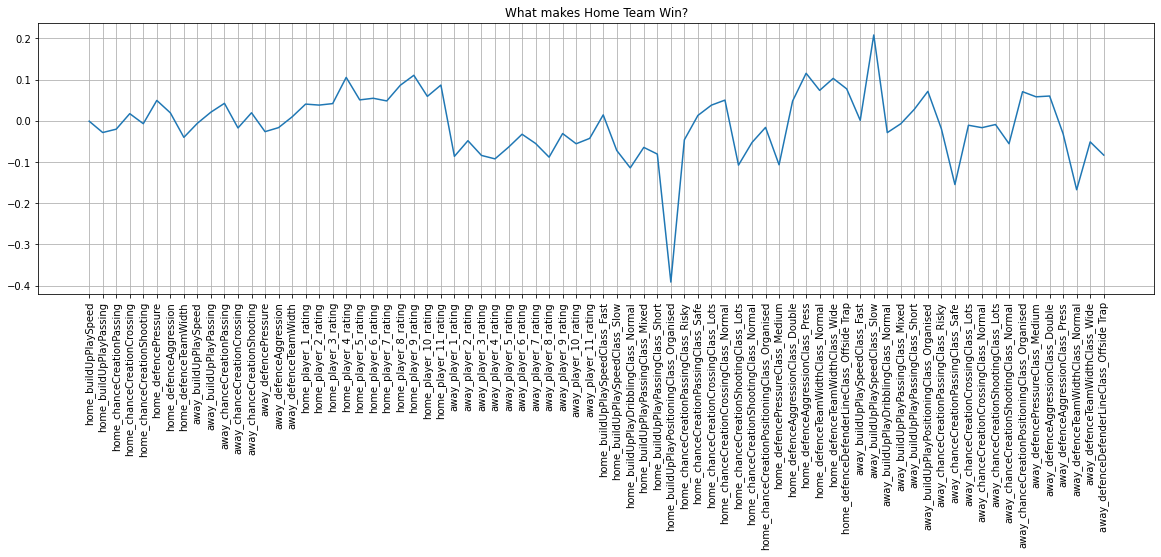

In [108]:
fig = plt.figure(figsize=(20, 5))
plt.plot(X.columns, model_lr.coef_[0])
plt.xticks(rotation=90)
plt.title('What makes Home Team Win?')
plt.grid()
plt.show()

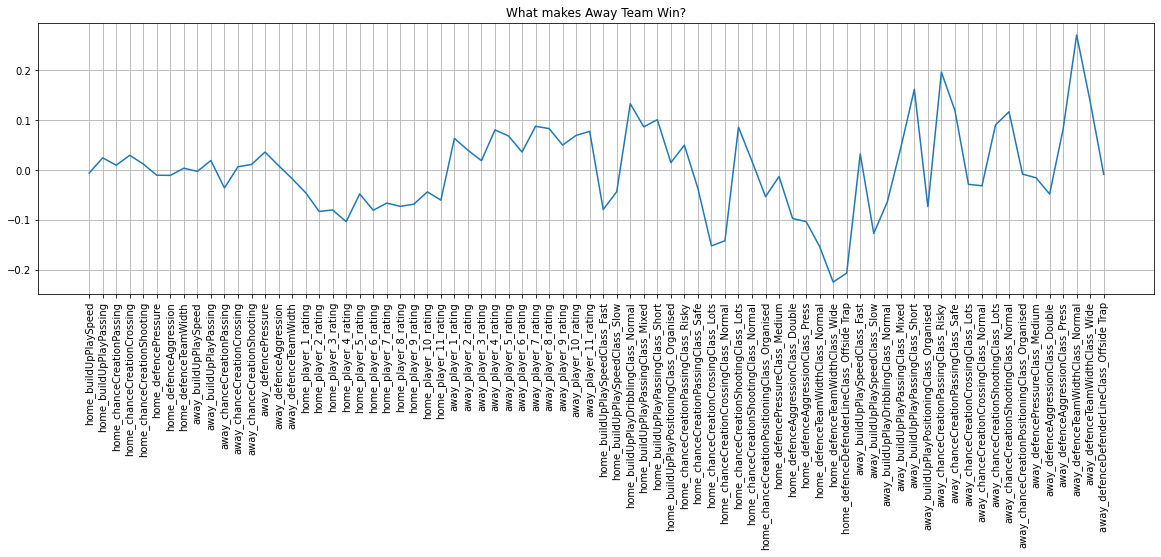

In [109]:
fig = plt.figure(figsize=(20, 5))
plt.plot(X.columns, model_lr.coef_[2])
plt.xticks(rotation=90)
plt.title('What makes Away Team Win?')
plt.grid()
plt.show()

- plot을 보면 홈, 어웨이 팀 선수들의 기량에 따라 결과가 좌우되는 것을 보임.

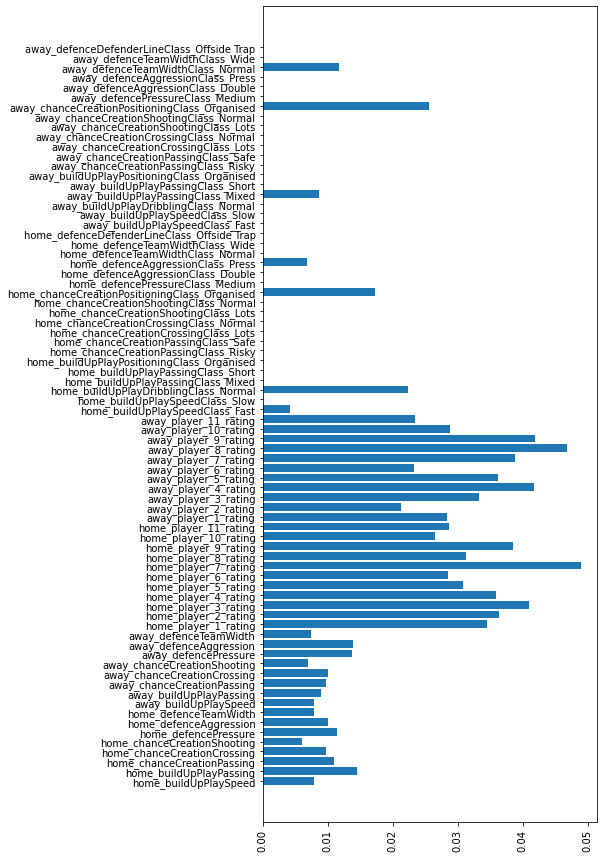

In [110]:
# XGBoost feature_importance_ plot하기
fig = plt.figure(figsize=(6, 15))
plt.barh(X.columns, model_xgb.feature_importances_)
plt.xticks(rotation=90)
plt.show()

- 팀에 대한 정보보다 선수들의 정보가 훨씬 중요하다는 결과!